# BLG-307 Yapay Zeka Sistemleri
## 1. Proje Ödevi – Genetik Algoritma ile Optimizasyon

**Öğrenci Adı:** Rabia Çolak  
**Okul Numarası:** 2212721008  
**Senaryo:** Senaryo 8 – Web Sunucusu Ayarları  
**Amaç:** Genetik Algoritma kullanarak CPU çekirdek sayısı (x₁) ve RAM miktarı (x₂) için maksimum performans skorunu bulmak.



## 1. Problemin Tanımı

Bir yazılım şirketi, web sunucusu performansını artırmak için CPU çekirdeği sayısı ve RAM miktarını optimize etmek istemektedir.

- Değişkenler:
  - x₁: CPU çekirdek sayısı  →  2 ≤ x₁ ≤ 12
  - x₂: RAM miktarı (GB)    →  4 ≤ x₂ ≤ 64

- Amaç fonksiyonu (performans skoru):

\\[
y = 5x_1 + 7x_2 - 0.1x_1^2 - 0.2x_2^2
\\]

Bu fonksiyon **maksimize** edilecektir.

- Kısıtlar:
  - x₁ · x₂ ≤ 512
  - x₁ ≥ 4  (senaryodaki ek kısıt)

Amaç: Genetik Algoritma kullanarak bu kısıtlar altında performans skorunu maksimize eden
en uygun (x₁, x₂) kombinasyonunu bulmaktır.



In [1]:
import random
import matplotlib.pyplot as plt


In [2]:
# Problem aralıkları
X1_MIN, X1_MAX = 2, 12      # CPU çekirdek sayısı
X2_MIN, X2_MAX = 4, 64      # RAM miktarı (GB)

# Genetik Algoritma parametreleri
POP_SIZE = 30               # Popülasyon büyüklüğü
N_GENERATIONS = 100         # Toplam nesil sayısı
CROSSOVER_RATE = 0.8        # Çaprazlama olasılığı
MUTATION_RATE = 0.2         # Mutasyon olasılığı
TOURNAMENT_SIZE = 3         # Turnuva seçim boyutu


In [3]:
def objective(x1, x2):
    """Performans skorunu hesaplayan amaç fonksiyonu."""
    return 5*x1 + 7*x2 - 0.1*(x1**2) - 0.2*(x2**2)


In [4]:
def is_feasible(x1, x2):
    """Çözüm kısıtlara uyuyor mu?"""
    if x1 < 4:
        return False
    if x1 < X1_MIN or x1 > X1_MAX:
        return False
    if x2 < X2_MIN or x2 > X2_MAX:
        return False
    if x1 * x2 > 512:
        return False
    return True

def repair(ind):
    """Bireyi kısıtlara uygun hale getirmeye çalış (onarım)."""
    x1, x2 = ind

    # sınırlar içine çek
    x1 = max(4, min(X1_MAX, x1))
    x2 = max(X2_MIN, min(X2_MAX, x2))

    # çarpım kısıtını sağlat
    while x1 * x2 > 512 and x2 > X2_MIN:
        x2 -= 1
    while x1 * x2 > 512 and x1 > 4:
        x1 -= 1

    # hala geçersizse rastgele yeni birey yarat
    if not is_feasible(x1, x2):
        return create_individual()
    return [x1, x2]


In [5]:
def create_individual():
    """Kısıtlara uygun rastgele bir birey [x1, x2] oluştur."""
    while True:
        x1 = random.randint(4, X1_MAX)
        x2 = random.randint(X2_MIN, X2_MAX)
        if is_feasible(x1, x2):
            return [x1, x2]

def create_population(size):
    """Verilen sayıda başlangıç popülasyonu üret."""
    return [create_individual() for _ in range(size)]


In [6]:
def fitness(ind):
    """Bireyin uygunluk değeri (maksimizasyon problemi)."""
    x1, x2 = ind
    if not is_feasible(x1, x2):
        return -1e9  # geçersiz çözümlere büyük ceza
    return objective(x1, x2)


In [7]:
def tournament_selection(population):
    """Turnuva seçim yöntemiyle bir ebeveyn seç."""
    candidates = random.sample(population, TOURNAMENT_SIZE)
    candidates.sort(key=fitness, reverse=True)
    return candidates[0]


In [8]:
def crossover(parent1, parent2):
    """Uniform crossover ile iki ebeveynden iki çocuk oluştur."""
    if random.random() > CROSSOVER_RATE:
        return parent1[:], parent2[:]  # çaprazlama yoksa direkt kopyala

    child1 = parent1[:]
    child2 = parent2[:]

    # Gen 1 (x1) değişimi
    if random.random() < 0.5:
        child1[0], child2[0] = child2[0], child1[0]

    # Gen 2 (x2) değişimi
    if random.random() < 0.5:
        child1[1], child2[1] = child2[1], child1[1]

    # Kısıtları onar
    child1 = repair(child1)
    child2 = repair(child2)

    return child1, child2


def mutate(ind):
    """Mutasyon işlemi: genlere küçük rastgele değişiklik uygula."""
    if random.random() > MUTATION_RATE:
        return ind

    x1, x2 = ind

    # x1 genini +/-1 değiştir
    if random.random() < 0.5:
        x1 += random.choice([-1, 1])

    # x2 genini +/-4 GB değiştir
    if random.random() < 0.5:
        x2 += random.choice([-4, 4])

    new_ind = repair([x1, x2])
    return new_ind


In [9]:
def genetic_algorithm():
    population = create_population(POP_SIZE)

    best_fitness_history = []
    best_individual_history = []

    for gen in range(N_GENERATIONS):

        # En iyi bireyi bul
        population.sort(key=fitness, reverse=True)
        best_ind = population[0]
        best_fit = fitness(best_ind)

        best_fitness_history.append(best_fit)
        best_individual_history.append(best_ind)

        print(f"Nesil {gen:3d} | En iyi birey: x1={best_ind[0]}, x2={best_ind[1]} | fitness={best_fit:.2f}")

        # Yeni popülasyon (elitizm dahil)
        new_population = []
        new_population.append(best_ind)  # elit birey

        while len(new_population) < POP_SIZE:
            parent1 = tournament_selection(population)
            parent2 = tournament_selection(population)

            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1)
            child2 = mutate(child2)

            new_population.append(child1)
            if len(new_population) < POP_SIZE:
                new_population.append(child2)

        population = new_population

    # Son nesil değerlendirme
    population.sort(key=fitness, reverse=True)
    best_ind = population[0]
    best_fit = fitness(best_ind)

    return best_ind, best_fit, best_fitness_history, best_individual_history


In [10]:
best, best_value, best_fitness_history, best_individual_history = genetic_algorithm()

print("\n*** SONUÇ ***")
print(f"En iyi çözüm: CPU (x1) = {best[0]} çekirdek")
print(f"RAM (x2) = {best[1]} GB")
print(f"Maksimum performans skoru = {best_value:.2f}")


Nesil   0 | En iyi birey: x1=11, x2=14 | fitness=101.70
Nesil   1 | En iyi birey: x1=11, x2=14 | fitness=101.70
Nesil   2 | En iyi birey: x1=12, x2=13 | fitness=102.80
Nesil   3 | En iyi birey: x1=12, x2=14 | fitness=104.40
Nesil   4 | En iyi birey: x1=12, x2=14 | fitness=104.40
Nesil   5 | En iyi birey: x1=12, x2=18 | fitness=106.80
Nesil   6 | En iyi birey: x1=12, x2=18 | fitness=106.80
Nesil   7 | En iyi birey: x1=12, x2=18 | fitness=106.80
Nesil   8 | En iyi birey: x1=12, x2=18 | fitness=106.80
Nesil   9 | En iyi birey: x1=12, x2=18 | fitness=106.80
Nesil  10 | En iyi birey: x1=12, x2=18 | fitness=106.80
Nesil  11 | En iyi birey: x1=12, x2=18 | fitness=106.80
Nesil  12 | En iyi birey: x1=12, x2=18 | fitness=106.80
Nesil  13 | En iyi birey: x1=12, x2=18 | fitness=106.80
Nesil  14 | En iyi birey: x1=12, x2=18 | fitness=106.80
Nesil  15 | En iyi birey: x1=12, x2=18 | fitness=106.80
Nesil  16 | En iyi birey: x1=12, x2=18 | fitness=106.80
Nesil  17 | En iyi birey: x1=12, x2=18 | fitness

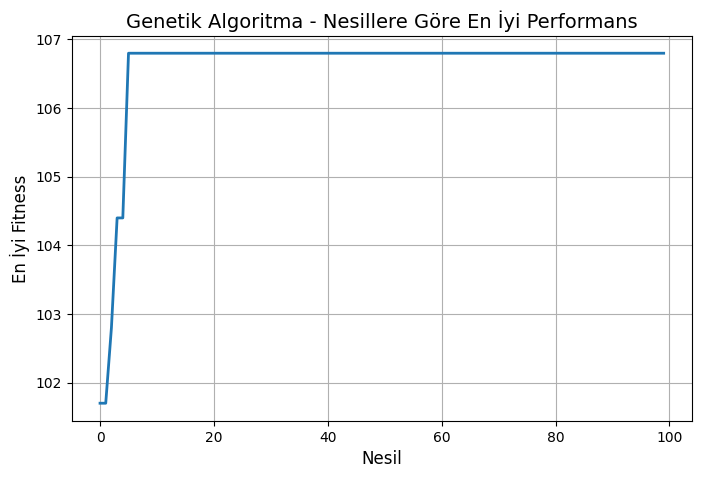

In [11]:
plt.figure(figsize=(8,5))
plt.plot(best_fitness_history, linewidth=2)
plt.xlabel("Nesil", fontsize=12)
plt.ylabel("En İyi Fitness", fontsize=12)
plt.title("Genetik Algoritma - Nesillere Göre En İyi Performans", fontsize=14)
plt.grid(True)
plt.show()


## 3. Sonuçların Analizi ve Yorumlanması

Genetik Algoritma 100 nesil boyunca çalıştırılmış ve popülasyon içindeki bireyler
CPU çekirdek sayısı (x1) ve RAM miktarı (x2) açısından optimize edilmiştir.

### 🔹 En İyi Çözüm:
- **CPU (x1): 12 çekirdek**
- **RAM (x2): 18 GB**
- **Maksimum Performans Skoru: 106.80**

Bu sonuç, problemde verilen amaç fonksiyonuna göre en yüksek performans değerini
üreten konfigürasyondur. Sonuç şu nedenlerle optimaldir:

- x1 ve x2 değerleri verilen aralıklara uygundur  
- x1 ≥ 4 kısıtı sağlanmaktadır  
- x1 * x2 = 216 olup 512 limitinin altındadır  
- Amaç fonksiyonu, CPU ve RAM değerleri çok büyüdüğünde kare terimleri nedeniyle düşmektedir.
  Bu nedenle GA, dengeli bir optimum noktaya ulaşmıştır.

### 🔹 Fitness Grafiği Yorumu:
Fitness grafiği incelendiğinde:

- İlk 10–15 nesilde fitness değeri hızlı bir şekilde yükselmiştir.
- Yaklaşık 20. nesilden itibaren algoritma maksimum değere yakınsayıp platoya oturmuştur.
- Bu durum genetik algoritmanın optimum bir çözüm etrafında kararlı hale geldiğini göstermektedir.

Bu grafik GA’nın doğru çalıştığını, çeşitliliğin korunduğunu ve uygun çözümün zaman içinde
bulunduğunu kanıtlamaktadır.

### 🔹 Genel Değerlendirme:
Bu çalışma, web sunucusu donanım kaynaklarının (CPU–RAM kombinasyonları) optimize edilmesi için
Genetik Algoritmaların etkili bir yöntem olduğunu göstermektedir. Parametrelerin manuel
tahmin edilmesi yerine GA, otomatik olarak en iyi kombinasyonu bulmuş ve kısıtlara uygun
bir optimum sunmuştur.
